# **Preprocessing of the Stanford Dogs Dataset**

The [Stanford Dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) contains 20,580 RGB images of 120 dog breeds, with 12,000 images for training and 8,500 for testing. Additionally, this dataset includes bounding boxes for each object in the images, where each image may contain between one and five dogs of the same breed. The dataset is widely used for Fine-Grained Image Classification, a challenging task compared to traditional image classification due to the presence of visually similar breeds that add complexity to the classification process.

The preprocessing steps in this notebook are designed for object detection using [Ultralytics' YOLO models](https://docs.ultralytics.com/models/yolo11/). While fine-grained classification is already complex, object detection for multiple similar classes is even more challenging. As a result, fine-tuning state-of-the-art models, such as YOLO11, is crucial in this case.

## **Imports**

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.io import loadmat
import xml.etree.ElementTree as ET
from google.colab import drive
from tqdm.auto import tqdm
from glob import glob
import pandas as pd
import shutil
import os

In [ ]:
# Mount Google Drive in Colab
drive.mount("/content/drive")

Mounted at /content/drive


## **Parameters**

In [ ]:
images_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
annotations_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
split_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar"

path_save_dataset = os.path.join(os.getcwd(), "StanfordDogs")
path_save_zip = "/content/drive/MyDrive/Datasets/StanfordDogs.zip"

os.makedirs(path_save_dataset, exist_ok=True)

## **Download and Extract the Dataset**

In [ ]:
images_path = tf.keras.utils.get_file(origin=images_url, cache_subdir=os.getcwd(), extract=True)
annotations_path = tf.keras.utils.get_file(origin=annotations_url, cache_subdir=os.getcwd(), extract=True)
split_path = tf.keras.utils.get_file(origin=split_url, cache_subdir=os.getcwd(), extract=True)

# Rename the paths of the images and annotations
images_path = os.path.join(os.path.dirname(images_path), "Images")
annotations_path = os.path.join(os.path.dirname(annotations_path), "Annotation")

793579520/793579520 ━━━━━━━━━━━━━━━━━━━━ 218s 0us/step
21852160/21852160 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
481280/481280 ━━━━━━━━━━━━━━━━━━━━ 2s 4us/step


In [ ]:
# Retrieve the paths of the training and testing images and annotations
train_images = loadmat("train_list.mat", squeeze_me=True)["file_list"]
train_annotations = loadmat("train_list.mat", squeeze_me=True)["annotation_list"]

test_images = loadmat("test_list.mat", squeeze_me=True)["file_list"]
test_annotations = loadmat("test_list.mat", squeeze_me=True)["annotation_list"]

print(len(train_images), len(train_annotations))
print(len(test_images), len(test_annotations))

12000 12000
8580 8580


## **Preprocess the Dataset**

In [ ]:
# Identify the names of each class
class_names = sorted([
    " ".join(name.replace("-", "_").split("_")[1:]).lower()
    for name in os.listdir(images_path)]
)
num_classes = len(class_names)

print(num_classes)
print(class_names)

120
['affenpinscher', 'afghan hound', 'african hunting dog', 'airedale', 'american staffordshire terrier', 'appenzeller', 'australian terrier', 'basenji', 'basset', 'beagle', 'bedlington terrier', 'bernese mountain dog', 'black and tan coonhound', 'blenheim spaniel', 'bloodhound', 'bluetick', 'border collie', 'border terrier', 'borzoi', 'boston bull', 'bouvier des flandres', 'boxer', 'brabancon griffon', 'briard', 'brittany spaniel', 'bull mastiff', 'cairn', 'cardigan', 'chesapeake bay retriever', 'chihuahua', 'chow', 'clumber', 'cocker spaniel', 'collie', 'curly coated retriever', 'dandie dinmont', 'dhole', 'dingo', 'doberman', 'english foxhound', 'english setter', 'english springer', 'entlebucher', 'eskimo dog', 'flat coated retriever', 'french bulldog', 'german shepherd', 'german short haired pointer', 'giant schnauzer', 'golden retriever', 'gordon setter', 'great dane', 'great pyrenees', 'greater swiss mountain dog', 'groenendael', 'ibizan hound', 'irish setter', 'irish terrier', '

In [ ]:
# Function to extract classes and the boxes coordinates and normalize them to the YOLO format
def parse_annotation(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()

  # Extract the dimensions of the image corresponding to the boxes
  width_img = int(root.find("size").find("width").text)
  height_img = int(root.find("size").find("height").text)

  labels = []
  for obj in root.iter("object"):
    # Find the ID of each class
    cls = obj.find("name").text.lower()
    cls = cls.replace("-", " ").replace("_", " ")
    cls = class_names.index(cls)

    # Extract the coordinates of the boxes
    box = obj.find("bndbox")
    xmin = float(box.find("xmin").text)
    ymin = float(box.find("ymin").text)
    xmax = float(box.find("xmax").text)
    ymax = float(box.find("ymax").text)

    # Normalize the coordinates
    x_center = (xmin + xmax) / (2 * width_img)
    y_center = (ymin + ymax) / (2 * height_img)
    width = (xmax - xmin) / width_img
    height = (ymax - ymin) / height_img

    labels.append([cls, x_center, y_center, width, height])

  return labels

In [ ]:
# Function to save the images and labels
def save_dataset(images, annotations, name="train"):
  path_data = os.path.join(path_save_dataset, name)
  path_imgs = os.path.join(path_data, "images")
  path_labels = os.path.join(path_data, "labels")

  os.makedirs(path_data, exist_ok=True)
  os.makedirs(path_imgs, exist_ok=True)
  os.makedirs(path_labels, exist_ok=True)

  for image, annotation in tqdm(zip(images, annotations), total=len(images)):
    image = os.path.join(images_path, image)
    annotation = os.path.join(annotations_path, annotation)
    labels = parse_annotation(annotation)
    id = image.split("/")[-1].split(".")[0]

    shutil.copy(image, os.path.join(path_imgs, f"{id}.jpg"))
    np.savetxt(
        os.path.join(path_labels, f"{id}.txt"),
        labels,
        fmt="%d %.6f %.6f %.6f %.6f"
    )

In [ ]:
save_dataset(train_images, train_annotations)
save_dataset(test_images, test_annotations, name="valid")

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/8580 [00:00<?, ?it/s]

In [ ]:
# Create the YAML file with the dataset metadata
with open(os.path.join(path_save_dataset, "data.yaml"), "w") as f:
  f.write(f"""
  path: StanfordDogs
  train: train/images
  val: valid/images

  nc: {num_classes}
  names: {class_names}
  """)

In [ ]:
# Compress the dataset into a zip file and save it
!zip -r $path_save_zip StanfordDogs -q

## **Visualization Example**

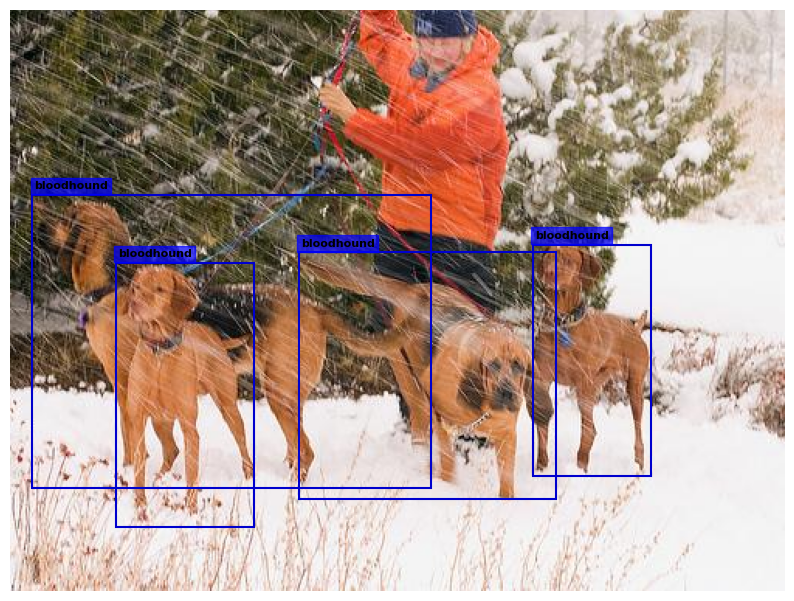

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 8))

image = Image.open("/content/StanfordDogs/train/images/n02088466_9167.jpg")
image = np.array(image)
shape = image.shape
ax.imshow(image)

annotation = np.loadtxt("/content/StanfordDogs/train/labels/n02088466_9167.txt")
annotation = annotation[None, :] if annotation.ndim == 1 else annotation
classes = annotation[:, 0]
boxes = annotation[:, 1:]

for i in range(len(boxes)):
  box = boxes[i]
  cls = classes[i].astype(np.int32)

  x_center, y_center, width, height = tuple(box)
  xmin = (x_center - width / 2) * shape[1]
  ymin = (y_center - height / 2) * shape[0]
  xmax = (x_center + width / 2) * shape[1]
  ymax = (y_center + height / 2) * shape[0]

  rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1.5, edgecolor="mediumblue", facecolor="none")
  ax.add_patch(rect)

  ax.text(
      x=xmin+shape[1]*0.002, y=ymin-shape[0]*0.007, s=f"{class_names[cls]}",
      color="black", fontsize=8, fontweight="bold", ha="left", va="bottom",
      bbox={"boxstyle":"square", "facecolor": "blue", "edgecolor":"blue", "alpha":0.7}
  )

ax.axis("off");

## **Dataset Analysis**

In [ ]:
# Calculate the number of images per class
train_image_count = np.unique(
    loadmat("train_list.mat", squeeze_me=True)["labels"],
    return_counts=True
)[1]

test_image_count = np.unique(
    loadmat("test_list.mat", squeeze_me=True)["labels"],
    return_counts=True
)[1]

print(train_image_count.min(), train_image_count.max())
print(test_image_count.min(), test_image_count.max())

100 100
48 152


It can be observed that the training dataset is balanced in terms of the number of images per class, as it contains 100 images for each class. However, the testing dataset is unbalanced, with the number of images per class ranging from 48 to 152.

In [ ]:
# Function to remove empty txt files and extract instance counts per class
def count_instances(path_data):
  dic_classes = {name: 0 for name in class_names}
  labels = glob(os.path.join(path_data, "labels/*.txt"))

  for label in labels:
    ids = np.loadtxt(label)
    ids = ids[None, :][:, 0] if ids.ndim == 1 else ids[:, 0]
    names = np.array(class_names)[ids.astype(np.int32)]

    for name in names:
      dic_classes[name] += 1

  df = pd.DataFrame(list(dic_classes.items()), columns=["Class", "Count"])
  df = df.sort_values(by="Count", ascending=False)

  return df

In [ ]:
num_train_instances = count_instances(os.path.join(path_save_dataset, "train"))
num_val_instances = count_instances(os.path.join(path_save_dataset, "valid"))

print(num_train_instances.info(), "\n")
print(num_val_instances.info())

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 39 to 17
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   120 non-null    object
 1   Count   120 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB
None 

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 1 to 89
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   120 non-null    object
 1   Count   120 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB
None


In [ ]:
pd.concat([num_train_instances.head(6), num_train_instances.tail(6)])

,Class,Count
39,english foxhound,130
1,afghan hound,127
2,african hunting dog,125
106,standard schnauzer,123
69,leonberg,121
59,irish wolfhound,121
45,french bulldog,101
47,german short haired pointer,100
22,brabancon griffon,100
12,black and tan coonhound,100


In [ ]:
num_val_instances

,Class,Count
1,afghan hound,160
73,maltese dog,157
59,irish wolfhound,142
97,scottish deerhound,138
69,leonberg,135
...,...,...
0,affenpinscher,51
85,pekinese,50
72,malinois,50
54,groenendael,50


The number of instances (dogs) per class in the training dataset ranges from 100 to 130, with only five classes having exactly 100 instances, meaning one instance per image. In contrast, the validation dataset shows greater variability, with the number of instances per class ranging from 48 to 160.

Overall, the training dataset is balanced for image classification tasks, as there are 100 images for each class. It can be considered approximately balanced for object detection tasks, with the number of instances per class varying between 100 and 130. Thus, there should be no issues when training or fine-tuning a model for either fine-grained image classification or object detection.